`(1) Testing the DBNet on Recipt Images`

In [ ]:
import os
os.chdir('/content/drive/MyDrive/SpeakingFridgey/text_detection/DB')

In [ ]:
!pip install -r requirement.txt

In [ ]:
os.chdir('/content/drive/MyDrive/SpeakingFridgey/text_detection/DB/assets/ops/dcn')
!python setup.py build_ext --inplace ## deformable convolution을 build하기 위함이다.

running build_ext
/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py:476: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py:387: UserWarning: The detected CUDA version (11.2) has a minor version mismatch with the version that was used to compile PyTorch (11.6). Most likely this shouldn't be a problem.
  warnings.warn(CUDA_MISMATCH_WARN.format(cuda_str_version, torch.version.cuda))
building 'deform_conv_cuda' extension
creating build/temp.linux-x86_64-3.8
creating build/temp.linux-x86_64-3.8/src
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 

In [ ]:
!pip install loguru

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 KB 6.3 MB/s eta 0:00:00


In [ ]:
os.chdir('/content/drive/MyDrive/SpeakingFridgey/text_detection/DB')
!python my_demo.py experiments/seg_detector/ic15_resnet50_deform_thre.yaml --image_path=pretrained/recipt41.png --resume=pretrained/stres50 --visualize --box_thresh 0.6

verbose: True
Initializing log dir for workspace/SegDetectorModel-seg_detector/deformable_resnet50/L1BalanceCELoss
2023-02-04 13:28:02.034 | INFO     | data.image_dataset:get_all_samples:41 - ./datasets/icdar2015/
2023-02-04 13:28:02.034 | INFO     | data.image_dataset:get_all_samples:42 - ./datasets/icdar2015/train_list.txt
2023-02-04 13:28:02.036 | INFO     | data.image_dataset:get_all_samples:41 - ./datasets/icdar2015/
2023-02-04 13:28:02.036 | INFO     | data.image_dataset:get_all_samples:42 - ./datasets/icdar2015/test_list.txt
Resuming from pretrained/stres50
Resumed from pretrained/stres50
2023-02-04 13:28:06.802 | INFO     | __main__:inference:149 - VISUALIZING


In [ ]:
!CUDA_VISIBLE_DEVICES=0 python train.py experiments/my_detector/base_fridgey.yaml

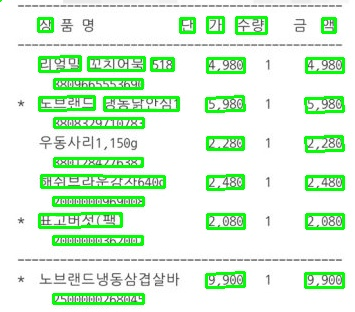

``` DBNet과 같은 Segmentation Based Text Detection의 문제
- 물론 데이터셋을 직접 모아서 학습을 시킨다면 다를수도 있겠으나
  -> 문제는 annotation정보가 정확한 document OCR dataset이 충분하지 않다는 것이다.
- 따라서 우리에게 제일 중요한 수량 정보가 오히려 인식이 잘 되지 않고, 즉 small text detection이 상대적으로 어려움을 알 수 있다.
-> 따라서 우선은 SROIE 데이터셋을 사용해서 CTPN을 추가적으로, 내가 원하는 대로 학습을 시켜보고자 한다.
  - 무조건 refinement stage를 추가할 생각이다.
- 특히나 CTPN의 경우에는 HORIZONTAL TEXT DETECTION에 매우 강한 성능을 보인다.
```

`CONFIG File for Training CTPN`

In [85]:
class ANCHOR_CFG(object):
  def __init__(self):
    self.FEATURE_STRIDE=16
    self.ANCHOR_SHIFT=16
    self.POSITIVE_LABEL=1
    self.NEGATIVE_LABEL=0
    self.IGNORE_LABEL=-1
    self.ANCHOR_N=12
    self.ANCHOR_HEIGHTS=[
        6, 11, 16, 27, 39, 52, 66, 81, 97, 115, 134, 154
    ]
    assert len(self.ANCHOR_HEIGHTS) == self.ANCHOR_N
    
    # -> 여기부터는 Anchor Generate하는 과정이다.
    self.POS_IOU_THRESH=0.5 # 0.7
    self.NEG_IOU_THRESH=0.3 # 0.5
    self.TRAINING_ANCHOR_N=128 # pos : neg = 1 : 1로 선정을 해서 학습시 matching anchor을 지정한다.

    # -> 여기부터는 예측을 바탕으로 preditcion box만들 때 사용
    self.CONFIDENCE_SCORE=0.8 # 해당 점수보다 text predict score이 높으면 text 영역으로 간주한다.
    self.VERTICAL_OVERLAP=0.7 # width가 다른 anchor과 thresh보다 많이 겹치면 같은 text line으로 간주한다.
    self.MAX_HORI_GAP=20 # 이웃 anchor과 떨어진 거리가 20보다 적으면 같은 text line으로 간주한다.
    self.MIN_SIZE_SIM=0.7 # 이웃 anchor과 IoU score이 0.7보다 크거나 같으면 같은 text line으로 간주한다.
    self.NMS_THRESH=0.3 # 만들어진 predicted text line과 IoU가 0.3보다 크면 제거한다.


`(2) CTPN Anchor Generation`

In [80]:
import numpy as np

class AnchorGenerator(object):
  def __init__(self, anchor_cfg):
    super(AnchorGenerator, self).__init__()
    self.anchor_cfg = anchor_cfg
    self.anchor_matcher = AnchorMatcher(anchor_cfg)

  def __call__(self, image_size, gt_boxes, return_anchors):
    H, W = image_size
    anchor_shift = self.anchor_cfg.ANCHOR_SHIFT

    feature_map_size = [int(np.ceil(H / anchor_shift)), int(np.ceil(W / anchor_shift))]
    anchor_boxes = self.generate_all_anchors(feature_map_size)
    matches = self.anchor_matcher(image_size, anchor_boxes=torch.as_tensor(anchor_boxes, device=torch.device('cpu')), gt_boxes = gt_boxes)

    if return_anchors:
      return matches + (anchor_boxes,)
    else:
      return matches


  def generate_anchors(self):
    anchor_heights = self.anchor_cfg.ANCHOR_HEIGHTS # list
    anchor_shift = self.anchor_cfg.ANCHOR_SHIFT # 이건 결국 anchor각가의 너비와 같다 (constant value를 사용함)
    basis_anchor = np.array([0, 0, anchor_shift- 1, anchor_shift-1], np.float32)
    heights = np.array(anchor_heights, dtype=np.float32)
    widths = np.ones(len(heights), dtype=np.float32) * anchor_shift
    sizes = np.column_stack((heights, widths))

    basic_anchors = []
    for n in range(len(anchor_heights)):
      H, W = sizes[n][0], sizes[n][1]
      scaled_anchor = basis_anchor.copy()
      center_x, center_y = (basis_anchor[0] + basis_anchor[2]) / 2., (basis_anchor[1] + basis_anchor[3]) / 2.
      scaled_anchor[0] = center_x - W / 2.
      scaled_anchor[1] = center_y - H / 2.
      scaled_anchor[2] = center_x + W / 2.
      scaled_anchor[3] = center_y + H / 2.

      basic_anchors.append(scaled_anchor)
    return np.array(basic_anchors)
  
  def generate_all_anchors(self, feature_map_size):
    basis_anchors = self.generate_anchors()
    anchor_n = basis_anchors.shape[0]

    feature_stride = self.anchor_cfg.FEATURE_STRIDE
    feat_map_h, feat_map_w = feature_map_size
    all_anchors = np.zeros(
        shape=(anchor_n * feat_map_h * feat_map_w, 4),
        dtype = np.float32
    )
    print(f"ANCHOR_N : {all_anchors.shape[0]}")
    index = 0
    for y in range(feat_map_h):
      for x in range(feat_map_w):
        shift = np.array([x, y, x, y]) * feature_stride
        all_anchors[index:index+anchor_n, :] = basis_anchors + shift
        index += anchor_n

    return all_anchors

0.4287109375 0.490234375


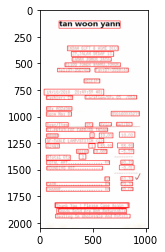

In [150]:
def order_point_clockwise(bboxes: np.ndarray) -> np.ndarray:
    """
    Order in clockwise the bounding box coordinates.
    Args:
        bboxes (numpy.ndarray): A numpy array containing the bounding box coordinates. Shape: [4, 2].
    Returns:
        An ordered clockwise bounding box.
    """
    if bboxes.ndim != 2 and bboxes.shape != (4, 2):
        raise ValueError("The bounding box coordinates are not in the correct shape!"
                         "It must be an numpy array of 2D whose shape is (4, 2).")

    # sort the points based on their x-coordinates
    xSorted = bboxes[np.argsort(bboxes[:, 0]), :]

    # grab the left-most and right-most points from the sorted
    # x-coordinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]

    # now, sort the left-most coordinates according to their
    # y-coordinates, so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (top_left, bottom_left) = leftMost

    # now, sort the right-most coordinates according to their
    # y-coordinates, so we can grab the top-right and bottom-right
    # points, respectively
    rightMost = rightMost[np.argsort(rightMost[:, 1]), :]
    (top_right, bottom_right) = rightMost

    # return the coordinates in this following order: top-left, top-right, bottom-right, and bottom-left
    return np.array([top_left, top_right, bottom_right, bottom_left])

def to_xy_min_max(bboxes: np.ndarray) -> List[int]:
    """
    Convert one bounding box whose form is: [x1, y1, x2, y2, x3, y3, x4, y4]
    into a box of form (xmin, ymin, xmax, ymax)
    Args:
        bboxes (numpy.ndarray): A numpy array containing the bounding box 8-coordinates.
    Returns:
        A list containing the bounding box 4-coordinates.
    """

    if len(bboxes) != 8:
        raise NotImplementedError("The bounding box coordinates must a length of 8!")

    Xs = bboxes[0::2]
    Ys = bboxes[1::2]

    xmin = int(round(np.min(Xs, 0)))
    ymin = int(round(np.min(Ys, 0)))
    xmax = int(round(np.max(Xs, 0)))
    ymax = int(round(np.max(Ys, 0)))

    final_boxes = [xmin, ymin, xmax, ymax]

    return final_boxes


def generate_gtboxes(txt_path, rescale_factor=1.0):
  gtboxes=[]
  with open(txt_path, 'r') as f:
    base_gtboxes = f.readlines()
    for line in base_gtboxes:
      coor_list = line.split(',')[:8]
      bbox = order_point_clockwise(np.array(list(map(np.float32, coor_list))).reshape((4, 2)))
      if cv2.arcLength(bbox, True) > 0:
        bbox = np.array(to_xy_min_max(bbox.flatten()))
        gtboxes.append(bbox)
  return np.array(gtboxes)

if __name__ == "__main__":
  import cv2, math
  box_dir = '/content/drive/MyDrive/SpeakingFridgey/SROIE2019/train/box/X00016469619.txt' #  '/content/drive/MyDrive/SpeakingFridgey/SROIE2019/train/box/X00016469612.txt' #
  img_dir = '/content/drive/MyDrive/SpeakingFridgey/SROIE2019/train/img/X00016469619.jpg' # '/content/drive/MyDrive/SpeakingFridgey/SROIE2019/train/img/X00016469612.jpg' # 
  with open(box_dir, 'r') as f:
    box_data = f.readlines()
  img = cv2.imread(img_dir)
  h, w,c = img.shape
  gt_boxes = generate_gtboxes(box_dir, rescale_factor=1.0)
  
  gt_boxes = torch.from_numpy(gt_boxes).float()
  img = cv2.resize(img, (1024, 2048))
  resize_w = 1024
  resize_h = 2048
  rescale_w = w / resize_w
  rescale_h = h / resize_h
  print(rescale_w, rescale_h)

  for box in gt_boxes:
    x1 = math.ceil(box[0] /rescale_w)
    x2 = math.floor(box[2] / rescale_w)
    y1 = math.ceil(box[1] / rescale_h)
    y2 = math.floor(box[3] / rescale_h)
    img=cv2.rectangle(img, (x1, y1), (x2, y2), 255, 3)
  plt.imshow(img)

In [82]:
print(len(torch.where(b[1] == 0)[0]))

48335


In [48]:
1000/16

62.5

In [49]:
1024/16

64.0

In [50]:
12 * 63 * 64

48384

In [46]:
torch.where(b[1] == 1)[0].shape

torch.Size([339])

In [48]:
b[0][:, :2] ## ((c_y - c_y_anchor) / h_anchor, log(h / h_anchor), offset)

tensor([[ 6.1667,  1.8718],
        [ 3.3636,  1.2657],
        [ 2.3125,  0.8910],
        ...,
        [-8.4435, -1.0814],
        [-7.2463, -1.2343],
        [-6.3052, -1.3734]])

In [ ]:
sample = torch.Tensor(b[:10])
sample = torch.unsqueeze(sample, dim=1)
sample.shape

torch.Size([10, 1, 4])

In [ ]:
print(b.shape) ## 총 anchor의 개수 -> (left x, top y, right x, bottom y)

(21504, 4)


`(3) CTPN Anchor & GTBox Matching`  

$IoU = Intersection / Union$

In [202]:
import torch
import torch.nn as nn

class AnchorMatcher(object):
  def __init__(self, anchor_cfg):
    super().__init__()
    self.anchor_cfg = anchor_cfg
    self.positive_label = self.anchor_cfg.POSITIVE_LABEL
    self.negative_label = self.anchor_cfg.NEGATIVE_LABEL
    self.ignore_label = self.anchor_cfg.IGNORE_LABEL
    self.pos_iou_thresh = self.anchor_cfg.POS_IOU_THRESH
    self.neg_iou_thresh = self.anchor_cfg.NEG_IOU_THRESH

  def compute_iou_score(self, anchor_boxes, gt_boxes):
    """Args
    anchor_boxes: [#anchor, 1, 4]
    gt_boxes: [1, #gt, 4]
    """
    intersection = self.compute_intersection(anchor_boxes, gt_boxes)
    anchor_box_area = (anchor_boxes[..., 2] - anchor_boxes[..., 0] + 1.) * (anchor_boxes[..., 3] - anchor_boxes[..., 1] + 1.)
    gt_box_area = (gt_boxes[..., 2] - gt_boxes[..., 0] + 1.) * (gt_boxes[..., 3] - gt_boxes[..., 1] + 1.)
    union = anchor_box_area + gt_box_area - intersection

    return (intersection) / (union + 1e-6)



  def compute_intersection(self, anchor_boxes, gt_boxes):
    """
    모든 anchor box와 gt box사이의 IoU를 구해야 하기 때문에 [#anchor, #gt]의 크기로 값을 구해야 한다.
    """
    n_anchor = anchor_boxes.shape[0]
    n_box = gt_boxes.shape[1]
    overlap_top_left = torch.maximum(
        anchor_boxes[..., :2], gt_boxes[...,:2]
    )
    overlap_bottom_right = torch.minimum(
        anchor_boxes[..., 2:], gt_boxes[..., 2:]
    )
    diff = overlap_bottom_right - overlap_top_left
    max_ = torch.maximum(diff, torch.as_tensor(0.0, device = gt_boxes.device))
    intersection = max_[..., 0] * max_[..., 1]

    return intersection

  def box_encode(self, matched_gt_boxes, anchor_boxes):
    """ Args
    matched_gt_boxes: [#box, 4]
    anchor_boxes: [#anchor, 4]
    """
    h =matched_gt_boxes[:, 3] - matched_gt_boxes[:, 1]
    ha = anchor_boxes[:, 3] - anchor_boxes[:, 1]
    c = (matched_gt_boxes[:, 3] + matched_gt_boxes[:, 1]) / 2. # matched_gt_boxes[:, 1] + h/2
    ca = (anchor_boxes[:, 3] + anchor_boxes[:, 1]) / 2. # anchor_boxes[:, 1] + ha/2
    cxa = (anchor_boxes[:, 0]+anchor_boxes[:, 2]) / 2.

    wa = self.anchor_cfg.ANCHOR_SHIFT
    def check_min_dist(a, b, c, d):
      min_dist = torch.tensor(10000.)
      for dist in ([a, b, c, d]):
        if torch.abs(min_dist) > torch.abs(dist):
          min_dist = dist
      return torch.unsqueeze(min_dist, 0)
    # 각각의 gt box는 anchor box와 연결이 되어 있음
    xside = torch.stack([
        check_min_dist(matched_gt[0] - anchor[0], matched_gt[2] - anchor[0], \
        matched_gt[0] - anchor[2], matched_gt[2] - anchor[2]) for (matched_gt, anchor) in zip(matched_gt_boxes, anchor_boxes)], dim=1)
    # xside, _ = torch.min(xside, dim=1)
    xside = torch.squeeze(xside, 0)
    
    Vc = (c - ca) / ha
    Vh = torch.log(h / ha)
    O = (xside - cxa) / wa

    bbox = torch.stack([Vc, Vh, O], dim=1)

    return bbox


  def __call__(self, image_size, anchor_boxes, gt_boxes):
    """ Args
    image_size: (H, W)의 tuple
    anchor_boxes: [# anchor, 4]
    gt_boxes: [#gt box, 4] -> 얘도 역시나 (left x, top y, right x, bottom y)로 정의
    """
    IoU = self.compute_iou_score(torch.unsqueeze(anchor_boxes, dim=1), gt_boxes=torch.unsqueeze(gt_boxes, dim=0))
    device = gt_boxes.device
    n_gt_boxes = IoU.size(1)
    # print(n_gt_boxes)
    anchor_labels = torch.full(size = (anchor_boxes.shape[0], ), fill_value = self.ignore_label, dtype = torch.int64)
    _, best_anchor_for_each_target_index = torch.max(IoU, dim=0, keepdim=False)

    best_target_for_each_anchor, best_target_for_each_anchor_index = torch.max(IoU, dim=1) # 각 anchor에 대해서 제일 높은 IoU를 (그나마도) 갖는 gt box와의 IoU, 그리고 gt box의 index
    best_target_for_each_anchor_index[best_anchor_for_each_target_index] = torch.arange(n_gt_boxes)

    best_target_for_each_anchor[best_anchor_for_each_target_index] = self.positive_label

    anchor_labels = anchor_labels[best_target_for_each_anchor_index] ## 각 gt box와 제일 높은 IoU를 갖는 anchor box가 positive
    anchor_labels[best_target_for_each_anchor > self.pos_iou_thresh] = self.positive_label ## gt box와 pos_thresh를 넘는 IoU를 갖는 anchor box가 positive
    anchor_labels[best_target_for_each_anchor < self.neg_iou_thresh] = self.negative_label
    
    img_h, img_w = image_size

    out_bound_anchors = torch.where( 
        (anchor_boxes[:, 0] < 0) | (anchor_boxes[:, 2] > img_w) | (anchor_boxes[:, 1] < 0) | (anchor_boxes[:, 3] > img_h) 
    )[0]

    gt_boxes = gt_boxes.squeeze(0)
    matched_gt_bboxes = gt_boxes[best_target_for_each_anchor_index]
    bbox_targets = self.box_encode(matched_gt_bboxes, anchor_boxes)

    output = (bbox_targets, anchor_labels)

    return output



`(4) CTPN Text Connector`

In [5]:
import numpy as np
from typing import Tuple, List
import os, sys

def fit_y(X, Y, x1, x2):
  if np.sum(X == X[0]) == len(X):
    return Y[0], Y[0]
  p = np.poly1d(np.polyfit(X, Y, 1))
  return p(x1), p(x2)

class Graph:
  def __init__(self, graph):
    self.graph = graph

  def sub_graphs_connected(self):
    sub_graphs = []
    for idx in range(self.graph.shape[0]):
      if not self.graph[:, idx].any() and self.graph[idx, :].any():
        v = idx
        sub_graphs.append([v])
        while self.graph[v, :].any():
          v = np.where(self.graph[v, :])[0][0]
          sub_graphs[-1].append(v)
    return sub_graphs

class TextProposalGraphBuilder(object):
  def __init__(self, anchor_cfg):
    self.anchor_cfg = anchor_cfg
    self.vertical_overlap = anchor_cfg.VERTICAL_OVERLAP
    self.min_size_sim = anchor_cfg.MIN_SIZE_SIM
    self.max_hori_gap = anchor_cfg.MAX_HORI_GAP
  
  def get_successions(self, idx):
    """ Args
    idx: 현재 vertex의 인덱스
    현재 탐색중인 text proposal과 같은 text line에 속하는 다른 text proposal을 찾는다.
    """
    current_box = self.text_proposals[idx]
    results = [] ## 같은 text line에 속하는 proposal의 index를 저장해서 return한다.
    # 현재 탐색중인 text proposal의 왼쪽 끝 x좌표부터 같은 text line에 속할 수 있는 최대 x방향 거리를 더한 값까지 (단, 이미지의 가로 길이를 넘으면 안됨)
    for left in range(int(current_box[0])-1, max(int(current_box[0]) + self.max_hori_gap+1, self.image_size[1])):
      neighbor_box_indices = self.boxes_table[left] # 해당 x축이 왼쪽 x끝인 text proposal들
      for neighbor_box_index in neighbor_box_indices:
        if self.meet_v_iou(neighbor_box_index, idx):
          results.append(neighbor_box_index)
        if len(results) != 0:
          return results
    return results

  def meet_v_iou(self, neighbor_box_index, idx):
    neighbor_box = self.text_proposals[neighbor_box_index]
    curr_box = self.text_proposals[idx]
    def check_vertical_overlap(neighbor_box, curr_box):
      neighbor_h = neighbor_box[3] - neighbor_box[1] + 1
      curr_h = curr_box[3] - curr_box[1] + 1
      y0 = max(curr_box[1], neighbor_box[1])
      y1 = min(neighbor_box[3], curr_box[3])
      return max(0, y1-y0+1) / min(neighbor_h, curr_h)
    
    def check_size_similarity(neighbor_box_index, idx):
      h1 = self.heights[neighbor_box_index]
      h2 = self.heights[idx]
      return min(h1, h2) / max(h1, h2)
  
    return check_vertical_overlap(neighbor_box, curr_box) >= self.vertical_overlap and check_size_similarity(neighbor_box_index, idx) >= self.min_size_sim
  
  def is_succession_node(self, idx, succession_index):
    presursors = self.get_precusors(succession_index)
    if self.scores[idx] >= np.max(self.scores[presursors]):
      return True
    return False

  def build_graph(self, text_proposals, scores, image_size):
    self.text_proposals = text_proposals
    self.scores = scores
    self.image_size = image_size
    self.heights = text_proposals[:, 3] - text_proposals[:, 1] + 1 ## 모델의 output을 decoding을 해서 (x1, y1, x2, y2)로 바꿔준게 text_proposals이다.
    boxes_tables = [[] for _ in range(self.image_size[1])]
    for idx, box in enumerate(text_proposals):
      boxes_tables[int(box[0])].append(idx) ## min_x의 좌표에 해당하는 anchor의 번호들을 넣어 준다.
    self.boxes_table = boxes_tables

    graph = np.zeros((text_proposals.shape[0], text_proposals.shape[0]), np.bool)

    for idx, box in enumerate(text_proposals):
      successions = self.get_successions(idx)
      if len(successions) == 0:
        continue
      succession_index = successions[np.argmax(scores[successions])]
      if self.is_succession_node(idx, succession_index):
        graph[idx, succession_index] = True
    G = Graph(graph=graph)

    return G

  def get_precusors(self, index):
    box = self.text_proposals[index]
    results = []
    for left in range(int(box[0])-1, max(int(box[0] - self.max_hori_gap), 0)-1, -1):
      neighbor_box_indices = self.boxes_table[left]
      for neighbor_box_index in neighbor_box_indices:
        if self.meet_v_iou(neighbor_box_index, index):
          results.append(neighbor_box_index)
      if len(results) != 0:
        return results
    return results
  

class TextProposalConnector(object):
  def __init__(self, anchor_cfg):
    super().__init__()
    self.anchor_cfg =anchor_cfg
    self.graph_builder = TextProposalGraphBuilder(anchor_cfg)
  
  def group_text_proposals(self, text_proposals, scores, image_size):
    graph = self.graph_builder.build_graph(text_proposals, scores=scores, image_size=image_size)
    return graph.sub_graphs_connected()

  def clip_boxes(self, text_lines, image_size):
    H, W = image_size
    zero = 0.0
    W_diff, H_diff = H-1., W-1.
    text_lines[:, 0::2] = np.maximum(np.minimum(text_lines[:, 0::2], W_diff), 0.0)
    text_lines[:, 1::2] = np.maximum(np.minimum(text_lines[:, 1::2], H_diff), 0.0)

    return text_lines

  def get_text_lines(self, text_proposals, scores, image_size):
    tp_groups = self.group_text_proposals(text_proposals, scores, image_size)
    text_lines = np.zeros((len(tp_groups), 4), dtype= np.float32)

    average_scores = []

    for idx, text_proposal_index in enumerate(tp_groups):
      text_line_boxes = text_proposals[list(text_proposal_index)]
      xmin = np.min(text_line_boxes[:, 0])
      xmax = np.max(text_line_boxes[:, 2])
      offset = (text_line_boxes[0, 2] - text_line_boxes[0,0]) / 2.
      lt_y, rt_y = fit_y(text_line_boxes[:, 0], text_line_boxes[:, 1], xmin+offset, xmax-offset)
      lb_y, rb_y = fit_y(text_line_boxes[:, 2], text_line_boxes[:,3], xmin+offset, xmax-offset)

      average_scores.append(scores[list(text_proposal_index)].sum() / float(len(text_proposal_index)))

      text_lines[idx, 0] = xmin
      text_lines[idx, 1] = min(lt_y, rt_y) ## ymin
      text_lines[idx, 2] = xmax
      text_lines[idx, 3] = max(lb_y, rb_y) ## ymax

    text_lines = self.clip_boxes(text_lines, image_size)
    average_scores = np.array(average_scores)

    return text_lines, average_scores


`(5) CTPN Text Detector`

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import sys, os

class TextDetector(object):
  def __init__(self, anchor_cfg):
    super().__init__()
    self.anchor_cfg = anchor_cfg
    self.confidence_score = anchor_cfg.CONFIDENCE_SCORE
    self.neighbor_iou = anchor_cfg.NEIGHBOR_IOU
    self.feature_stride = anchor_cfg.FEATURE_STRIDE
    self.anchor_shift = anchor_cfg.ANCHOR_SHIFT
    self.anchor_generator = AnchorGenerator(self.anchor_cfg)
    self.text_proposal_connector = TextProposalConnector(self.anchor_cfg)
  
  def decode(self, predicted_bboxes, anchor_boxes):
    anchor_height = anchor_boxes[:, 3] - anchor_boxes[:, 1] + 1.
    anchor_center_y = (anchor_boxes[:, 1] + anchor_boxes[:, 3]) / 2.
    gt_center_y = predicted_bboxes[..., 0] * anchor_height + anchor_center_y
    gt_height = np.exp(predicted_bboxes[...,1]) * anchor_height

    x1 = anchor_boxes[:, 0]
    y1 = gt_center_y - gt_height / 2.
    x2 = anchor_boxes[:, 1]
    y2 = gt_center_y + gt_height / 2.

    bboxes = np.stack([
        x1, y1.squeeze(), x2, y2.squeeze()
    ], axis= 1)

    return bboxes

  def nms(self, bboxes, scores):
    # (1) confidence score이 높은 순서대로 box를 정렬한다.
    score_indices = np.argsort(scores, kind= 'mergesort', axis=-1)[::-1] ## 오름차순으로 정렬이 되었으니 역순으로 변경
    candidates = []
    # (2) bbox의 영역 넓이를 우선 구해준다.
    xmin, xmax = bboxes[:, 0], bboxes[:,2]
    ymin, ymax = bboxes[:, 1] , bboxes[:, 3]
    areas = (xmax - xmin+1) * (ymax-ymin+1)

    # (3) conf score이 높은 bbox부터 선택후 IoU가 높은 다른 box 제거
    while score_indices.size > 0:
      cur_idx = score_indices[0]
      candidates.append(cur_idx)

      xxmax = np.maximum(xmin[cur_idx], xmin[score_indices[1:]])
      xxmin = np.minimum(xmax[cur_idx], xmax[score_indices[1:]])
      yymax = np.maximum(ymin[cur_idx], ymin[score_indices[1:]])
      yymin = np.minimum(ymax[cur_idx], ymax[score_indices[1:]])

      W = np.maximum(0.0, xxmin - xxmax)
      H = np.maximum(0.0, yymin - yymax)

      overlap = W * H ## (교집합)
      remain = areas[score_indices[1:]] ## remaining areas (차집합)
      aou = areas[cur_idx] + remain - overlap ## area of union
      IoU = overlap / aou

      indices = np.where(IoU <= self.neighbor_iou)[0]
      score_indices = score_indices[indices+1]
    return candidates
    
  def __call__(self, predictions, image_size):
    H, W = image_size
    predicted_bboxes, predicted_scores, predicted_refinement = predictions # 근데 refinement정보는 사용하지 않음
    predicted_scores = torch.softmax(predicted_scores, dim=2)
    predicted_bboxes = predicted_bboxes.cpu().numpy()
    predicted_scores = predicted_scores.cpu().numpy()

    feature_map_size = [int(np.ceil(H / self.anchor_shift), int(np.ceil(W / self.anchor_shift)))]
    anchor_boxes = self.anchor_generator.generate_all_anchors(feature_map_size = feature_map_size)

    decoded_bboxes = self.decode(predicted_bboxes=predicted_bboxes, anchor_boxes=anchor_boxes)
    clipped_bboxes = self.text_proposal_connector.clip_boxes(decoded_bboxes, image_size)

    text_class = 1
    conf_scores = predicted_scores[0, :, text_class]
    conf_scores_mask = np.where(conf_scores > self.confidence_score) # confidence점수가 기준보다 높으면 text 영역으로 간주
    conf_scores_mask = conf_scores_mask[0]

    selected_bboxes = clipped_bboxes[conf_scores_mask,:]
    selected_scores = predicted_scores[0, conf_scores_mask, text_class]

    candidates = self.nms(bboxes=selected_bboxes, scores=selected_scores)

    selected_bboxes = selected_bboxes[candidates, :]
    selected_scores = selected_scores[candidates, :]
    text_lines, scores = self.text_proposal_connector.get_text_lines(
        text_proposals=selected_bboxes,
        scores=selected_scores,
        image_size=image_size
    )

    return text_lines, scores


`(6) CTPN Model`

In [7]:
import torch
import torch.nn as nn
from torchvision import models
!pip install einops
from einops import rearrange

class CTPN(nn.Module):
  def __init__(self,
               n_classes=2, ## Text Area vs Background Area
               f_out_channels=512,
               n_anchors=10, ## 각각의 feature map의 pixel마다의 anchor의 개수 (만약에 feature map을 8배로만 줄인다면 어떨까?)
               hidden_size=128,
               pretrained_backbone=True):
    super(CTPN, self).__init__()
    self.n_classes = n_classes
    self.hidden_size = hidden_size
    self.pretrained_backbone = pretrained_backbone

    ## (1) Pretrained 2D Backbone (=VGG16)
    try:
      vgg = models.vgg16(weights = models.VGG16_Weights.IMAGENET1K_V1)
    except:
      vgg = models.vgg16(pretrained=True)
    self.vgg_layers = nn.Sequential(*list(vgg.features)[:-1])

    ## (2) RPN Layer
    self.rpn = nn.Sequential(
        nn.Conv2d(in_channels=f_out_channels, out_channels=f_out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=True),
        nn.ReLU(inplace=True)
    )

    ## (3) BiLSTM Layer
    self.rnn = nn.LSTM(input_size=f_out_channels, hidden_size=self.hidden_size, num_layers=2, bidirectional=True, batch_first=True)
  
    ## (4) FC Layer
    self.fc = nn.Linear(self.hidden_size*2, f_out_channels, bias=True)

    ## (5) CLS Layer
    self.cls = nn.Conv2d(in_channels=f_out_channels, out_channels=n_anchors * n_classes, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=True)

    ## (6) Regression Layer
    self.reg = nn.Conv2d(in_channels=f_out_channels, out_channels = n_anchors * 2, kernel_size = (1, 5), stride=(1, 1), padding=(0,2), bias=True)

    ## (7) Refinement Layer
    self.refine = nn.Conv2d(in_channels=f_out_channels, out_channels=n_anchors, kernel_size=(1, 5), stride=(1, 2), padding=(0, 2), bias=True)

    self.reset_parameters()

  def reset_parameters(self):
    for name, named_child in self.named_children():
      if name == 'rnn':
        for param in named_child.parameters():
          if len(param.shape) >= 2:
            nn.init.orthogonal_(param.data)
          else:
            nn.init.zeros_(param.data)
            nn.init.ones_(param.data[self.hidden_size:self.hidden_size*2])
      elif not self.pretrained_backbone or name != "vgg_layers":
        for layer in named_child.modules():
          if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            nn.init.kaiming_normal_(layer.weight, a = 0.0, mode='fan_in', nonlinearity='relu')
            if layer.bias is not None:
              nn.init.constant_(layer.bias, val=0.0)

  def forward(self, inputs):
    backbone_features = self.vgg_layers(inputs)
    rpn_features = self.rpn(backbone_features)
    rpn_size = (rpn_features.size(0), rpn_features.size(1), rpn_features.size(2), rpn_features.size(3))
    rpn_features = rearrange(rpn_features, 'b c h w -> b h w c')
    rpn_features = rpn_features.contiguous().view(-1, rpn_features.size(2), rpn_features.size(3))

    rnn_features, _ = self.rnn(rpn_features)
    fc_features = self.fc(rnn_features)

    fc_features = fc_features.contiguous().view(rpn_size[0], rpn_size[2], rpn_size[3], rpn_size[1])
    fc_features = fc_features.permute(0, 3, 1, 2).contiguous()
    
    reg_features = self.reg(fc_features)
    cls_features = self.cls(fc_features)
    refine_features = self.refine(fc_features)

    reg_features = reg_features.permute(0, 2, 3, 1)
    cls_features = cls_features.permute(0, 2, 3, 1)
    refine_features = refine_features.permute(0, 2, 3, 1)

    reg_features = reg_features.contiguous().view(reg_features.size(0), -1, 2)
    cls_features = cls_features.contiguous().view(cls_features.size(0), -1, self.n_classes)
    refine_features = refine_features.contiguous().view(refine_features.size(0), -1, 1)

    return reg_features, cls_features, refine_features

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [222]:
if __name__ == "__main__":
  ctpn = CTPN()
  for name, child in ctpn.named_children():
    if name  == 'vgg_layers':
      cnt=0
      for idx, layer in enumerate(child):
        if isinstance(layer, nn.Conv2d):
          for param in layer.parameters():
            param.requires_grad = False
          cnt += 1
        if cnt == 2:
          break

0
1


`(7) CTPN Dataset`

In [151]:
class DATA_CONFIG(object):
  def __init__(self):
    self.IMAGE_PIXEL_STD = [0.20037157, 0.18366718, 0.19631825]
    self.IMAGE_PIXEL_MEAN = [0.90890862, 0.91631571, 0.90724233]
    self.RPN_POSITIVE_NUM=64
    self.RPN_NUM=128
    self.IMAGE_H=2048
    self.IMAGE_W=1024
    self.MAX_SCALE=1000
    self.DATA_DIR='/content/drive/MyDrive/SpeakingFridgey/SROIE2019'

In [216]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

def order_point_clockwise(bboxes: np.ndarray) -> np.ndarray:
  """
  Order in clockwise the bounding box coordinates.
  Args:
        bboxes (numpy.ndarray): A numpy array containing the bounding box coordinates. Shape: [4, 2].
  Returns:
        An ordered clockwise bounding box.
  """
  if bboxes.ndim != 2 and bboxes.shape != (4, 2):
    raise ValueError("The bounding box coordinates are not in the correct shape!"
                         "It must be an numpy array of 2D whose shape is (4, 2).")

  # sort the points based on their x-coordinates
  xSorted = bboxes[np.argsort(bboxes[:, 0]), :]

  # grab the left-most and right-most points from the sorted
  # x-coordinate points
  leftMost = xSorted[:2, :]
  rightMost = xSorted[2:, :]

  # now, sort the left-most coordinates according to their
  # y-coordinates, so we can grab the top-left and bottom-left
  # points, respectively
  leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
  (top_left, bottom_left) = leftMost

  # now, sort the right-most coordinates according to their
  # y-coordinates, so we can grab the top-right and bottom-right
  # points, respectively
  rightMost = rightMost[np.argsort(rightMost[:, 1]), :]
  (top_right, bottom_right) = rightMost

  # return the coordinates in this following order: top-left, top-right, bottom-right, and bottom-left
  return np.array([top_left, top_right, bottom_right, bottom_left])

def to_xy_min_max(bboxes: np.ndarray) -> List[int]:
  """
  Convert one bounding box whose form is: [x1, y1, x2, y2, x3, y3, x4, y4]
  into a box of form (xmin, ymin, xmax, ymax)
  Args:
        bboxes (numpy.ndarray): A numpy array containing the bounding box 8-coordinates.
  Returns:
        A list containing the bounding box 4-coordinates.
    """

  if len(bboxes) != 8:
    raise NotImplementedError("The bounding box coordinates must a length of 8!")

  Xs = bboxes[0::2]
  Ys = bboxes[1::2]

  xmin = int(round(np.min(Xs, 0)))
  ymin = int(round(np.min(Ys, 0)))
  xmax = int(round(np.max(Xs, 0)))
  ymax = int(round(np.max(Ys, 0)))

  final_boxes = [xmin, ymin, xmax, ymax]

  return final_boxes


def generate_gtboxes(txt_path, rescale_factor):
  gtboxes=[]
  with open(txt_path, 'r') as f:
    base_gtboxes = f.readlines()
    for line in base_gtboxes:
      coor_list = line.split(',')[:8]
      bbox = order_point_clockwise(np.array(list(map(np.float32, coor_list))).reshape((4, 2)))
      if cv2.arcLength(bbox, True) > 0:
        bbox = np.array(to_xy_min_max(bbox.flatten()))
        gtboxes.append(bbox)
  return np.array(gtboxes)

def data_transform_before_matching(image_size, new_image_size, gt_box, anchor_shift):
  img_w, img_h = image_size[0], image_size[1]
  new_w, new_h = new_image_size[0], new_image_size[1]
  ratio_w = new_w / img_w
  ratio_h = new_h / img_h
  gt_box *= np.array([[ratio_w, ratio_h, ratio_w, ratio_h]])
  # print(torch.from_numpy(gt_box))

  new_gt_boxes = []
  for i, box in enumerate(gt_box):
    xmin, ymin, xmax, ymax = box
    box_ids = np.arange(int(np.floor(1.0 * xmin / anchor_shift)), int(np.ceil(1.0 * xmax / anchor_shift)))
    new_bboxes = np.zeros(shape = (len(box_ids), 4))
    new_bboxes[:, 0] = box_ids * anchor_shift
    new_bboxes[:, 1] = ymin
    new_bboxes[:, 2] = (box_ids + 1.0) * anchor_shift
    new_bboxes[:,3] = ymax
    new_gt_boxes.append(new_bboxes)
  new_gt_bboxes = np.concatenate(new_gt_boxes, axis=0)
  return new_gt_bboxes

class FridgeyDataset(Dataset):
  def __init__(self, data_cfg, anchor_cfg, mode='train'):
    super(FridgeyDataset, self).__init__()
    self.data_cfg = data_cfg
    self.anchor_cfg = anchor_cfg
    self.anchor_generator = AnchorGenerator(anchor_cfg)
    self.data_dir = os.path.join(self.data_cfg.DATA_DIR, mode)
    self.label_dir = os.path.join(self.data_dir, 'box')
    self.img_names = os.listdir(os.path.join(self.data_dir, 'img'))

  def __len__(self):
    return len(self.img_names)

  def __getitem__(self, idx):
    img_name = self.img_names[idx]
    img_path = os.path.join(self.data_dir, 'img', img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    h, w, c = img.shape
    resize_h, resize_w = self.data_cfg.IMAGE_H, self.data_cfg.IMAGE_W
    rescale_fac = [h / resize_h, w/resize_w] # max(h, w) / self.data_cfg.MAX_SCALE
    
    img = cv2.resize(img, (resize_w, resize_h))
    img = np.array(img)
    
    gt_path = os.path.join(self.label_dir, img_name.split('.')[0] + '.txt')
    gtbox = generate_gtboxes(gt_path, rescale_factor = rescale_fac)
    gtbox = gtbox.astype(np.float)
    
    initial_gtbox = torch.from_numpy(gtbox) ## 16개로 나누기전에 사용한 gtbox

    gtbox = data_transform_before_matching((w, h), new_image_size=(resize_w, resize_h), gt_box = gtbox, anchor_shift=self.anchor_cfg.ANCHOR_SHIFT)

    img = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=self.data_cfg.IMAGE_PIXEL_MEAN, std=self.data_cfg.IMAGE_PIXEL_STD)
    ])(img)
    gtbox = torch.from_numpy(gtbox).float()

    reg_target, cls_target = self.anchor_generator((resize_h, resize_w), gtbox, False)
    fg_index = torch.where(cls_target == 1)[0]

    if (len(fg_index) > self.data_cfg.RPN_POSITIVE_NUM):
      cls_target[np.random.choice(fg_index, len(fg_index) - self.data_cfg.RPN_POSITIVE_NUM, replace= False)] = -1

    bg_index = torch.where(cls_target == 0)[0]
    rpn_negative_num = self.data_cfg.RPN_NUM - min(len(fg_index), self.data_cfg.RPN_POSITIVE_NUM)
    if (len(bg_index) > rpn_negative_num):
      cls_target[np.random.choice(bg_index, len(bg_index) - rpn_negative_num, replace=False)]=-1
      
    return img, reg_target, cls_target, {"initial_gtbox": initial_gtbox, "image_dir": img_path}



In [212]:
if __name__== "__main__":
  dataset = FridgeyDataset(data_cfg=DATA_CONFIG(), anchor_cfg = ANCHOR_CFG())
  dataloader = DataLoader(dataset, shuffle=True, batch_size=1)
  for idx, batch in enumerate(dataloader):
    break

<ipython-input-211-95d85403a76d>:128: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gtbox = gtbox.astype(np.float)


ANCHOR_N : 98304


In [213]:
img, reg_target, cls_target, more_data = batch

In [214]:
gtbox.shape

torch.Size([1, 968, 4])

In [207]:
reg_target[0][:, -1]

tensor([  10.5625,   10.5625,   10.5625,  ..., -113.4375, -113.4375,
        -113.4375])

In [184]:
for b in range(reg_target.shape[0]):
  print(torch.where(cls_target[b] == 1)[0].shape[0])

64


True

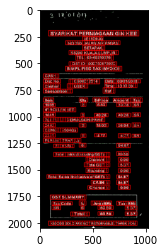

In [215]:
import matplotlib.pyplot as plt
sample_image = img[0].cpu().permute(1, 2, 0).numpy().astype(np.uint8).copy()
gtbox = more_data['initial_gtbox']
for box in gtbox[0]:
  box = [int(x) for x in box]
  x1,y1,x2, y2 = box
  cv2.rectangle(sample_image, (x1, y1), (x2, y2), 255, 3)
plt.imshow(sample_image)
cv2.imwrite('/content/drive/MyDrive/SpeakingFridgey/demo/test.jpg', sample_image)

`(8) CTPN Loss Function`

In [208]:
class LOSS_CFG(object):
  def __init__(self):
    self.LAMBDA_REG=1.0
    self.LAMBDA_REFINE=2.0
    self.LAMBDA_CLS=1.0

    self.ALPHA=0.5
    self.GAMMA=1.5
    self.BETA=1.0
    self.REDUCTION='none'
  

In [225]:
import torch
import torch.nn as nn

class BalancedL1Loss(nn.Module):
  def __init__(self, loss_cfg):
    super(BalancedL1Loss).__init__()
    self.loss_cfg = loss_cfg
    self.alpha = loss_cfg.ALPHA
    self.gamma = loss_cfg.GAMMA
    self.beta = loss_cfg.BETA
    self.reduction = loss_cfg.REDUCTION

  
  def forward(self, inputs: torch.Tensor, targets: torch.Tensor):
    if targets.numel() == 0:
      return inputs.sum() * 0
    x = torch.abs(inputs - targets)
    b = torch.exp(torch.as_tensor(self.gamma / self.alpha)) - 1.0
    loss = torch.where(
        x < self.beta,
        self.alpha / b *(b*x+1) * torch.log(b * x / self.beta+1) - self.alpha * x,
        self.gamma * x + self.gamma / b - self.alpha * self.beta
    )
    if self.reduction == 'mean':
      loss = loss.mean()
    elif self.reduction == 'sum':
      loss = loss.sum()
    else:
      pass
    return loss

class MultiBoxLoss(nn.Module):
  def __init__(self, loss_cfg, anchor_cfg):
    super(MultiBoxLoss, self).__init__()
    self.lambda_reg = loss_cfg.LAMBDA_REG
    self.lambda_refine = loss_cfg.LAMBDA_REFINE
    self.lambda_cls = loss_cfg.LAMBDA_CLS
    self.ignore_index = anchor_cfg.IGNORE_LABEL
    self.positive_index = anchor_cfg.POSITIVE_LABEL
    self.negative_index = anchor_cfg.NEGATIVE_LABEL
    self.l1_loss = BalancedL1Loss(loss_cfg)
    self.ce_loss = nn.CrossEntropyLoss(ignore_index = self.ignore_index, reduction='none')
  
  def forward(self, predictions, reg_target, cls_target):
    predicted_bboxes, predicted_classes, predicted_refinement = predictions
    gt_bboxes, matching_indicators = reg_target, cls_target #  targets  ## reg_target, cls_target
    box_gt, refine_gt = gt_bboxes[:, :2], gt_bboxes[:, 2]

    positive_anchor_mask = matching_indicators == self.positive_index
    negative_anchor_mask = matching_indicators == self.negative_index
    
    reg_loss = self.l1_loss(inputs = predicted_bboxes[positive_anchor_mask], targets=box_gt[positive_anchor_mask])
    refine_loss = self.l1_loss(inputs = predicted_refinement[positive_anchor_mask], targets=refine_gt[positive_anchor_mask])

    Nv = reg_loss.size(0)

    reg_loss = (self.lambda_reg / Nv) * reg_loss.sum()
    refine_loss = (self.lambda_refine / Nv) * refine_loss.sum()

    n_classes = predicted_classes.size(2)

    pos_conf_loss = self.ce_loss(
        input = predicted_classes[positive_anchor_mask].contiguous().view(-1, n_classes),
        target = matching_indicators[positive_anchor_mask].contiguous().view(-1)
    )

    neg_conf_loss = self.ce_loss(
        input = predicted_classes[negative_anchor_mask].contiguous().view(-1, n_classes),
        target = matching_indicators[negative_anchor_mask].contiguous().view(-1)
    )

    k_pos_anchors = positive_anchor_mask.long().sum()
    all_negatives = negative_anchor_mask.long().sum()
    k_negatives = k_pos_anchors * self.neg_pos_ratio
    k = min(k_negatives, all_negatives)

    hard_negative_conf_loss,  _ = torch.topk(input = neg_conf_loss, k = int(k), largest = True, sorted=True)
    Ns = torch.count_nonzero(pos_conf_loss) + torch.count_nonzero(hard_negative_conf_loss)

    cls_pos = pos_conf_loss.sum()
    cls_neg = hard_negative_conf_loss.sum()
    conf_loss = (self.lambda_cls / Ns) * (cls_pos + cls_neg)

    return conf_loss, reg_loss, refine_loss

`(9) CTPN Training`

In [223]:
class TRAIN_CFG(object):
  def __init__(self):
    self.BATCH_SIZE=8
    self.LEARNING_RATE=0.001
    self.FIRST_STEP=16000
    self.SECOND_STEP=40000
    self.EVAL_STEP=3000
    self.SAVE_STEP=1000
    self.MOMENTUM=0.9
    self.WEIGHT_DECAY=0.0005
    self.RESULT_PATH='/content/drive/MyDrive/SpeakingFridgey/text_detection/CTPN_TRAINING_RESULT'


In [224]:
import torch
import torch.nn as nn
!pip install loguru
from loguru import logger

class Trainer(object):
  def __init__(self, exp, train_cfg, anchor_cfg, data_cfg, loss_cfg):
    super(Trainer, self).__init__()
    self.exp = exp
    os.makedirs(os.path.join(data_cfg.RESULT_PATH, exp), exist_ok=True)
    self.train_cfg = train_cfg
    self.anchor_cfg = anchor_cfg
    self.data_cfg = data_cfg
    self.loss_cfg = loss_cfg
    self.text_detector = TextDetector(anchor_cfg)
    self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  
  def build_things(self):
    train_dataset = FridgeyDataset(self.data_cfg, self.anchor_cfg, mode='train')
    test_dataset = FridgeyDataset(self.data_cfg, self.anchor_cfg, mode='test')
    self.train_loader = DataLoader(train_dataset, self.data_cfg.BATCH_SIZE, shuffle=True)
    self.test_loader = DataLoader(test_dataset, 1, shuffle=False)

    self.model = CTPN()
    self.model = self.model.to(self.device)
    self.freeze_vgg()
    self.optimizer = torch.optim.SGD(self.model.parameters(), lr = self.train_cfg.LEARNING_RATE, \
                                     momentum = self.train_cfg.MOMENTUM, weight_decay = self.train_cfg.WEIGHT_DECAY)
    self.criterion = MultiBoxLoss(self.loss_cfg, self.anchor_cfg)
  
  def train_start(self):
    tot_iteration = 0
    one_epoch_iter = len(self.train_loader)
    first_step_iter = self.train_cfg.FIRST_STEP
    entire_step_iter = self.train_cfg.SECOND_STEP + first_step_iter
    total_epoch = math.ceil(entire_step_iter / one_epoch_iter)

    for epoch in range(total_epoch):
      loop = tqdm(self.train_loader)
      self.model.train()
      for idx, batch in enumerate(loop):
        img, reg_target, cls_target, _ = batch
        predictions = self.model(img.to(self.device))
        conf_loss, reg_loss, refine_loss = self.criterion(predictions, reg_target.to(self.device), cls_target.to(self.device))
        loss = conf_loss + reg_loss + refine_loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        loop.set_postfix({"ITERATION" : tot_iteration, "LOSS" : loss.detach().clone(), "REG LOSS" : reg_loss.detach().clone(),\
                          "REFINE_LOSS" : refine_loss.detach().clone(), "CLS_LOSS": cls_loss.detach().clone()})
        tot_iteration += 1
        if (tot_iteration == first_step_iter):
          for g in self.optimizer.param_groups:
            g['lr'] = self.train_cfg.LEARNING_RATE * 0.1
        if (tot_iteration == entire_step_iter):
          logger.info("====Training Iteration Ended====")
        if (tot_iteration + 1) % self.train_cfg.EVAL_STEP == 0:
          self.test_model()
        if (tot_iteration + 1) % self.train_cfg.SAVE_STEP == 0:
          self.save_ckpt(tot_iteration)
  
  def save_ckpt(self,  iteration):
    self.save_dir = os.path.join(self.data_cfg.RESULT_PATH, self.exp, 'model_ckpt')
    os.makedirs(self.save_dir, exist_ok=True)
    torch.save(self.model, os.path.join(self.save_dir, f"{iteration}.pth"))
    logger.info(f"===SAVED {iteration} MODEL WEIGHTS===")

  def test_model(self):
    loop = tqdm(self.test_loader)
    self.model.eval()
    for idx, batch in enumerate(loop):
      img, reg_target, cls_target, more_data = batch
      predictions = self.model(img.to(self.device))
      conf_loss, reg_loss, refine_loss = self.criterion(predictions, reg_target.to(self.device), cls_target.to(self.device))
      loss = conf_loss + reg_loss + refine_loss
      image_size = (self.data_cfg.IMAGE_H, self.data_cfg.IMAGE_W)

      self.save_predictions(predictions, image_size, more_data)

      loop.set_postfix({"EVALUATION ITER" : idx, "LOSS" : loss.detach().clone(), "REG LOSS" : reg_loss.detach().clone(),\
                          "REFINE_LOSS" : refine_loss.detach().clone(), "CLS_LOSS": cls_loss.detach().clone()})
      # text_lines, scores = self.text_detector(predictions, image_size)
      # iou_score = self.evaluate_iou(predictions, image_size=image_size, gt_textbox = more_data['initial_gtbox'])

  def save_predictions(self, predictions, image_size, more_data):
    detected_bboxes , _ = self.text_detector(predictions, image_size)
    org_image = cv2.imread(more_data['image_dir'])
    org_image = cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB)
    image_id = more_data['image_dir'].split('/')[-1].split('.')[0]
    org_h, org_w, _ = org_image.shape

    ratio_w = org_w / image_size[1]
    ratio_h = org_h / image_size[0]
    size_ = np.array([[ratio_w, ratio_h, ratio_w, ratio_h]])
    detected_bboxes *= size_

    with open(os.path.join(self.train_cfg.RESULT_PATH,self.exp, image_id, 'txt'), 'w') as f:
      for j, coords in enumerate(detected_bboxes):
        xmin, ymin, xmax, ymax = coords
        w = xmax - xmin
        h = ymax-ymin
        dw = w * 0.01
        dh = h * 0.05
        box = [xmin-dw, ymin-dh, xmax+dw, ymax +dh, xmax + dw, ymax + dh, nmin-dw, ymax + dh]
        line = ",".join(str(round(coord)) for coord in box)
        line += '\n'
        f.write(line)

        drawn_image = cv2.rectangle(org_image, (xmin, ymin), (xmax, ymax), 255, 3)

    cv2.imwrite(os.path.join(self.train_cfg.RESULT_PATH, self.exp, image_id, 'png'), drawn_image)


  @staticmethod
  def evaluate_iou(predictions, image_size, gt_textbox):
    bs = predictions.shape[0]
    for b in range(bs):
      pred = predictions[b]
      gt = gt_textbox[b]
      # (1) gt text box와 predicted text box의 iou score을 우선적으로 계산을 하고


  def freeze_vgg(self):
    for name, child in self.model.named_children():
      if name  == 'vgg_layers':
        cnt=0
        for idx, layer in enumerate(child):
          if isinstance(layer, nn.Conv2d):
            for param in layer.parameters():
              param.requires_grad = False
            cnt += 1
          if cnt == 2:
            break

In [ ]:
if __name__ == "__main__":
  EXP_NAME=input()
  TRAINER = Trainer(
      EXP_NAME, TRAIN_CFG(), ANCHOR_CFG(), DATA_CFG(), LOSS_CFG()
  )

`(10) CTPN Detection Prediction Bot`

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

